# Data Preparation



## Feature Extraction

In [ ]:
!pip install opencv-python
!pip install opencv-contrib-python

In [2]:
import os
import cv2
from skimage import exposure
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import feature, io, filters
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

     ---------------------------------------- 39.5/39.5 MB 8.2 MB/s eta 0:00:00
     ---------------------------------------- 46.2/46.2 MB 3.0 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage import feature, io
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.util import img_as_ubyte

class FeatureExtraction():
    def __init__(self):
        self.LBP = 'lbp'
        self.PCA = 'pca'
        self.FFT = 'fft'
        self.image_size = (240, 240)

    def extract_labels(self):
        paths = []
        non_valid_files = ['810199515_real_none_jungle_10', '810199515_real_none_jungle_1', 'desktop.ini', '810100473_real_none_sea_4']

        for image_path in os.listdir(self.image_dir):
            try:
                if not any(non_valid_file in image_path for non_valid_file in non_valid_files):
                    paths.append(image_path)
            except Exception as e:
                print(e)
                continue

        data = {0: paths}
        return pd.DataFrame(data)

   
    def lbp(self, path):
        try:
            image_path = os.path.join(self.image_dir, path)
            image = io.imread(image_path)
            if image.ndim == 3:
                from skimage.color import rgb2gray
                image = rgb2gray(image)

            image = resize(image, self.image_size)
            image = img_as_ubyte(image)
            lbp = feature.local_binary_pattern(image, 8, 1, method='uniform')
            histogram, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
            return histogram
        except Exception as e:
            print(f"[LBP ERROR] {path}: {e}")
            return np.zeros(58)  # Return dummy vector of correct size

    def fft(self, path):
        try:
            image_path = os.path.join(self.image_dir, path)
            image = io.imread(image_path)
            if image.ndim == 3:
                from skimage.color import rgb2gray
                image = rgb2gray(image)

            resized_image = resize(image, self.image_size)
            fft_image = np.fft.fft2(resized_image)
            fft_shifted = np.fft.fftshift(fft_image)
            magnitude_spectrum = np.log(1 + np.abs(fft_shifted))
            return magnitude_spectrum.flatten()
        except Exception as e:
            print(f"[FFT ERROR] {path}: {e}")
            return np.zeros(self.image_size[0] * self.image_size[1])  # Dummy FFT vector

    def extract(self):
        self.df = self.extract_labels()

        tqdm.pandas()
        self.df['lbp'] = self.df[0].progress_apply(lambda path: self.lbp(path))
        self.lbp_df = pd.DataFrame(self.df['lbp'].values.tolist())
        print("LBP DONE")

        tqdm.pandas()
        self.df['fft'] = self.df[0].progress_apply(lambda path: self.fft(path))
        self.fft_df = pd.DataFrame(self.df['fft'].values.tolist())
        print("FFT DONE")

        return self.df, pd.concat([self.lbp_df, self.fft_df], axis=1)

    def pca(self, df):
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
        pca = PCA(n_components=512)
        X_pca = pca.fit_transform(df_scaled)
        return pd.DataFrame(X_pca)

    def run(self, real_dir, fake_dir):
        self.image_dir = real_dir
        real_labels, real_features = self.extract()

        self.image_dir = fake_dir
        fake_labels, fake_features = self.extract()

        h_features = pd.concat([real_features, fake_features], axis=0)
        h_labels = pd.concat([real_labels, fake_labels], axis=0)

        return self.pca(h_features), h_labels.drop(['lbp', 'fft'], axis=1)


In [4]:
real_dir = r"C:\Desktop\MLAssignment\real"
fake_dir = r"C:\Desktop\MLAssignment\fake"

feature_extraction = FeatureExtraction()
h_features, h_labels = feature_extraction.run(real_dir, fake_dir)


 22%|█████████████████▎                                                             | 375/1707 [02:41<04:25,  5.01it/s]

[LBP ERROR] 810100469_real_none_mountain_ (2).jpg: the input array must have size 3 along `channel_axis`, got (720, 480, 4)


 22%|█████████████████▍                                                             | 377/1707 [02:41<03:31,  6.28it/s]

[LBP ERROR] 810100469_real_none_mountain_ (5).jpg: the input array must have size 3 along `channel_axis`, got (1102, 735, 4)


 24%|███████████████████▎                                                           | 416/1707 [02:57<01:58, 10.92it/s]

[LBP ERROR] 810100473_real_none_sea_5.jpeg.png: the input array must have size 3 along `channel_axis`, got (444, 710, 4)


 29%|███████████████████████▎                                                       | 503/1707 [03:10<01:28, 13.60it/s]

[LBP ERROR] 810101087_real_none_sea_1.jpeg: the input array must have size 3 along `channel_axis`, got (600, 800, 4)


 53%|█████████████████████████████████████████▊                                     | 904/1707 [11:40<01:15, 10.59it/s]

[LBP ERROR] 810197238_real_none_jungle_2.jpeg: the input array must have size 3 along `channel_axis`, got (598, 810, 4)
[LBP ERROR] 810197238_real_none_jungle_3.jpeg: the input array must have size 3 along `channel_axis`, got (538, 814, 4)
[LBP ERROR] 810197238_real_none_jungle_4.jpeg: the input array must have size 3 along `channel_axis`, got (544, 818, 4)


 53%|██████████████████████████████████████████                                     | 908/1707 [11:40<01:12, 11.02it/s]

[LBP ERROR] 810197238_real_none_jungle_5.jpeg: the input array must have size 3 along `channel_axis`, got (540, 814, 4)
[LBP ERROR] 810197238_real_none_jungle_6.jpeg: the input array must have size 3 along `channel_axis`, got (884, 814, 4)
[LBP ERROR] 810197238_real_none_jungle_7.jpeg: the input array must have size 3 along `channel_axis`, got (540, 818, 4)


 53%|██████████████████████████████████████████▏                                    | 912/1707 [11:40<01:00, 13.09it/s]

[LBP ERROR] 810197238_real_none_jungle_8.jpeg: the input array must have size 3 along `channel_axis`, got (614, 812, 4)
[LBP ERROR] 810197238_real_none_jungle_9.jpeg: the input array must have size 3 along `channel_axis`, got (542, 816, 4)
[LBP ERROR] 810197238_real_none_mountain_1.jpeg: the input array must have size 3 along `channel_axis`, got (534, 814, 4)
[LBP ERROR] 810197238_real_none_mountain_10.jpeg: the input array must have size 3 along `channel_axis`, got (538, 816, 4)


 54%|██████████████████████████████████████████▍                                    | 916/1707 [11:41<00:52, 14.99it/s]

[LBP ERROR] 810197238_real_none_mountain_2.jpeg: the input array must have size 3 along `channel_axis`, got (540, 816, 4)
[LBP ERROR] 810197238_real_none_mountain_3.jpeg: the input array must have size 3 along `channel_axis`, got (570, 818, 4)
[LBP ERROR] 810197238_real_none_mountain_4.jpeg: the input array must have size 3 along `channel_axis`, got (544, 818, 4)
[LBP ERROR] 810197238_real_none_mountain_5.jpeg: the input array must have size 3 along `channel_axis`, got (542, 816, 4)


 54%|██████████████████████████████████████████▍                                    | 918/1707 [11:41<00:54, 14.48it/s]

[LBP ERROR] 810197238_real_none_mountain_6.jpeg: the input array must have size 3 along `channel_axis`, got (538, 818, 4)
[LBP ERROR] 810197238_real_none_mountain_7.jpeg: the input array must have size 3 along `channel_axis`, got (624, 814, 4)
[LBP ERROR] 810197238_real_none_mountain_8.jpeg: the input array must have size 3 along `channel_axis`, got (510, 814, 4)
[LBP ERROR] 810197238_real_none_mountain_9.jpeg: the input array must have size 3 along `channel_axis`, got (508, 816, 4)


 54%|██████████████████████████████████████████▋                                    | 923/1707 [11:41<00:48, 16.20it/s]

[LBP ERROR] 810197238_real_none_sea_1.jpeg: the input array must have size 3 along `channel_axis`, got (544, 812, 4)
[LBP ERROR] 810197238_real_none_sea_10.jpeg: the input array must have size 3 along `channel_axis`, got (540, 818, 4)
[LBP ERROR] 810197238_real_none_sea_2.jpeg: the input array must have size 3 along `channel_axis`, got (506, 794, 4)
[LBP ERROR] 810197238_real_none_sea_3.jpeg: the input array must have size 3 along `channel_axis`, got (508, 818, 4)


 54%|██████████████████████████████████████████▉                                    | 927/1707 [11:41<00:49, 15.64it/s]

[LBP ERROR] 810197238_real_none_sea_4.jpeg: the input array must have size 3 along `channel_axis`, got (546, 814, 4)
[LBP ERROR] 810197238_real_none_sea_5..jpeg: the input array must have size 3 along `channel_axis`, got (542, 814, 4)
[LBP ERROR] 810197238_real_none_sea_6.jpeg: the input array must have size 3 along `channel_axis`, got (532, 808, 4)
[LBP ERROR] 810197238_real_none_sea_7.jpeg: the input array must have size 3 along `channel_axis`, got (536, 814, 4)


 54%|██████████████████████████████████████████▉                                    | 929/1707 [11:41<00:48, 16.06it/s]

[LBP ERROR] 810197238_real_none_sea_8.jpeg: the input array must have size 3 along `channel_axis`, got (542, 816, 4)
[LBP ERROR] 810197238_real_none_sea_9.jpeg: the input array must have size 3 along `channel_axis`, got (456, 814, 4)


 56%|████████████████████████████████████████████▏                                  | 956/1707 [11:52<01:44,  7.21it/s]

[LBP ERROR] 810197636_real_none_sea_4.jpeg: the input array must have size 3 along `channel_axis`, got (874, 1366, 4)
[LBP ERROR] 810197636_real_none_sea_5.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810197636_real_none_sea_5.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 66%|███████████████████████████████████████████████████▌                          | 1128/1707 [14:42<00:53, 10.89it/s]

[LBP ERROR] 810199311_real_none_mountain_6.jpeg: the input array must have size 3 along `channel_axis`, got (562, 982, 4)


 67%|███████████████████████████████████████████████████▉                          | 1136/1707 [14:44<01:26,  6.60it/s]

[LBP ERROR] 810199311_real_none_sea_3.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199311_real_none_sea_3.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 810199311_real_none_sea_4.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199311_real_none_sea_4.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 810199311_real_none_sea_5.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199311_real_none_sea_5.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 810199311_real_none_sea_6.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199311_real_none_sea_6.jpeg`` with iomode `ri`.
Based on the extension, the following plu

 67%|████████████████████████████████████████████████████                          | 1138/1707 [14:44<01:09,  8.14it/s]

[LBP ERROR] 810199311_real_none_sea_7.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199311_real_none_sea_7.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 85%|██████████████████████████████████████████████████████████████████▏           | 1448/1707 [23:05<00:30,  8.55it/s]

[LBP ERROR] 810199515_real_none_jungle_9.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199515_real_none_jungle_9.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 86%|██████████████████████████████████████████████████████████████████▉           | 1466/1707 [23:09<00:48,  4.96it/s]

[LBP ERROR] 810199515_real_none_sea_6.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199515_real_none_sea_6.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 810199515_real_none_sea_8.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199515_real_none_sea_8.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1607/1707 [29:26<00:24,  4.04it/s]

[LBP ERROR] 810701006_real_none_mountain_7.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810701006_real_none_mountain_7.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1661/1707 [29:43<00:10,  4.48it/s]

[LBP ERROR] 830400052_real_none_mountain_1.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\830400052_real_none_mountain_1.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1667/1707 [29:45<00:11,  3.57it/s]

[LBP ERROR] 830400052_real_none_mountain_8.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\830400052_real_none_mountain_8.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


100%|██████████████████████████████████████████████████████████████████████████████| 1707/1707 [29:55<00:00,  1.05s/it]


LBP DONE


 22%|█████████████████▎                                                             | 375/1707 [02:29<03:02,  7.29it/s]

[FFT ERROR] 810100469_real_none_mountain_ (2).jpg: the input array must have size 3 along `channel_axis`, got (720, 480, 4)


 22%|█████████████████▍                                                             | 377/1707 [02:29<02:54,  7.61it/s]

[FFT ERROR] 810100469_real_none_mountain_ (5).jpg: the input array must have size 3 along `channel_axis`, got (1102, 735, 4)


 24%|███████████████████▏                                                           | 414/1707 [02:43<02:20,  9.18it/s]

[FFT ERROR] 810100473_real_none_sea_5.jpeg.png: the input array must have size 3 along `channel_axis`, got (444, 710, 4)


 29%|███████████████████████▏                                                       | 502/1707 [02:55<01:15, 16.03it/s]

[FFT ERROR] 810101087_real_none_sea_1.jpeg: the input array must have size 3 along `channel_axis`, got (600, 800, 4)


 53%|█████████████████████████████████████████▊                                     | 904/1707 [11:08<01:16, 10.52it/s]

[FFT ERROR] 810197238_real_none_jungle_2.jpeg: the input array must have size 3 along `channel_axis`, got (598, 810, 4)
[FFT ERROR] 810197238_real_none_jungle_3.jpeg: the input array must have size 3 along `channel_axis`, got (538, 814, 4)
[FFT ERROR] 810197238_real_none_jungle_4.jpeg: the input array must have size 3 along `channel_axis`, got (544, 818, 4)


 53%|██████████████████████████████████████████                                     | 908/1707 [11:08<01:07, 11.85it/s]

[FFT ERROR] 810197238_real_none_jungle_5.jpeg: the input array must have size 3 along `channel_axis`, got (540, 814, 4)
[FFT ERROR] 810197238_real_none_jungle_6.jpeg: the input array must have size 3 along `channel_axis`, got (884, 814, 4)
[FFT ERROR] 810197238_real_none_jungle_7.jpeg: the input array must have size 3 along `channel_axis`, got (540, 818, 4)


 53%|██████████████████████████████████████████                                     | 910/1707 [11:09<00:59, 13.44it/s]

[FFT ERROR] 810197238_real_none_jungle_8.jpeg: the input array must have size 3 along `channel_axis`, got (614, 812, 4)
[FFT ERROR] 810197238_real_none_jungle_9.jpeg: the input array must have size 3 along `channel_axis`, got (542, 816, 4)
[FFT ERROR] 810197238_real_none_mountain_1.jpeg: the input array must have size 3 along `channel_axis`, got (534, 814, 4)
[FFT ERROR] 810197238_real_none_mountain_10.jpeg: the input array must have size 3 along `channel_axis`, got (538, 816, 4)


 54%|██████████████████████████████████████████▍                                    | 916/1707 [11:09<00:46, 16.99it/s]

[FFT ERROR] 810197238_real_none_mountain_2.jpeg: the input array must have size 3 along `channel_axis`, got (540, 816, 4)
[FFT ERROR] 810197238_real_none_mountain_3.jpeg: the input array must have size 3 along `channel_axis`, got (570, 818, 4)
[FFT ERROR] 810197238_real_none_mountain_4.jpeg: the input array must have size 3 along `channel_axis`, got (544, 818, 4)
[FFT ERROR] 810197238_real_none_mountain_5.jpeg: the input array must have size 3 along `channel_axis`, got (542, 816, 4)
[FFT ERROR] 810197238_real_none_mountain_6.jpeg: the input array must have size 3 along `channel_axis`, got (538, 818, 4)


 54%|██████████████████████████████████████████▋                                    | 922/1707 [11:09<00:40, 19.58it/s]

[FFT ERROR] 810197238_real_none_mountain_7.jpeg: the input array must have size 3 along `channel_axis`, got (624, 814, 4)
[FFT ERROR] 810197238_real_none_mountain_8.jpeg: the input array must have size 3 along `channel_axis`, got (510, 814, 4)
[FFT ERROR] 810197238_real_none_mountain_9.jpeg: the input array must have size 3 along `channel_axis`, got (508, 816, 4)
[FFT ERROR] 810197238_real_none_sea_1.jpeg: the input array must have size 3 along `channel_axis`, got (544, 812, 4)
[FFT ERROR] 810197238_real_none_sea_10.jpeg: the input array must have size 3 along `channel_axis`, got (540, 818, 4)


 54%|██████████████████████████████████████████▊                                    | 926/1707 [11:09<00:42, 18.21it/s]

[FFT ERROR] 810197238_real_none_sea_2.jpeg: the input array must have size 3 along `channel_axis`, got (506, 794, 4)
[FFT ERROR] 810197238_real_none_sea_3.jpeg: the input array must have size 3 along `channel_axis`, got (508, 818, 4)
[FFT ERROR] 810197238_real_none_sea_4.jpeg: the input array must have size 3 along `channel_axis`, got (546, 814, 4)
[FFT ERROR] 810197238_real_none_sea_5..jpeg: the input array must have size 3 along `channel_axis`, got (542, 814, 4)


 54%|██████████████████████████████████████████▉                                    | 928/1707 [11:10<00:43, 17.92it/s]

[FFT ERROR] 810197238_real_none_sea_6.jpeg: the input array must have size 3 along `channel_axis`, got (532, 808, 4)
[FFT ERROR] 810197238_real_none_sea_7.jpeg: the input array must have size 3 along `channel_axis`, got (536, 814, 4)
[FFT ERROR] 810197238_real_none_sea_8.jpeg: the input array must have size 3 along `channel_axis`, got (542, 816, 4)
[FFT ERROR] 810197238_real_none_sea_9.jpeg: the input array must have size 3 along `channel_axis`, got (456, 814, 4)


 56%|████████████████████████████████████████████▎                                  | 958/1707 [11:19<01:21,  9.24it/s]

[FFT ERROR] 810197636_real_none_sea_4.jpeg: the input array must have size 3 along `channel_axis`, got (874, 1366, 4)
[FFT ERROR] 810197636_real_none_sea_5.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810197636_real_none_sea_5.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 66%|███████████████████████████████████████████████████▌                          | 1128/1707 [14:12<00:39, 14.62it/s]

[FFT ERROR] 810199311_real_none_mountain_6.jpeg: the input array must have size 3 along `channel_axis`, got (562, 982, 4)


 67%|███████████████████████████████████████████████████▉                          | 1137/1707 [14:14<01:05,  8.69it/s]

[FFT ERROR] 810199311_real_none_sea_3.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199311_real_none_sea_3.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 810199311_real_none_sea_4.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199311_real_none_sea_4.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 810199311_real_none_sea_5.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199311_real_none_sea_5.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 810199311_real_none_sea_6.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199311_real_none_sea_6.jpeg`` with iomode `ri`.
Based on the extension, the following plu

 67%|████████████████████████████████████████████████████                          | 1139/1707 [14:14<01:00,  9.36it/s]

[FFT ERROR] 810199311_real_none_sea_7.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199311_real_none_sea_7.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 85%|██████████████████████████████████████████████████████████████████▎           | 1450/1707 [22:49<00:23, 11.09it/s]

[FFT ERROR] 810199515_real_none_jungle_9.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199515_real_none_jungle_9.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 86%|██████████████████████████████████████████████████████████████████▉           | 1466/1707 [22:52<00:42,  5.70it/s]

[FFT ERROR] 810199515_real_none_sea_6.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199515_real_none_sea_6.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 810199515_real_none_sea_8.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810199515_real_none_sea_8.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1607/1707 [29:07<00:27,  3.58it/s]

[FFT ERROR] 810701006_real_none_mountain_7.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\810701006_real_none_mountain_7.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1661/1707 [29:23<00:10,  4.22it/s]

[FFT ERROR] 830400052_real_none_mountain_1.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\830400052_real_none_mountain_1.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1666/1707 [29:25<00:13,  2.97it/s]

[FFT ERROR] 830400052_real_none_mountain_8.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\real\830400052_real_none_mountain_8.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


100%|██████████████████████████████████████████████████████████████████████████████| 1707/1707 [29:34<00:00,  1.04s/it]


FFT DONE


 24%|██████████████████▉                                                            | 410/1710 [00:55<02:07, 10.18it/s]

[LBP ERROR] 810100473_fake_stable_jungle_1.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)
[LBP ERROR] 810100473_fake_stable_jungle_2.jpeg.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810100473_fake_stable_jungle_3.jpeg.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810100473_fake_stable_jungle_4.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)
[LBP ERROR] 810100473_fake_stable_jungle_5.jpeg.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 24%|███████████████████▏                                                           | 414/1710 [00:55<01:50, 11.68it/s]

[LBP ERROR] 810100473_fake_stable_mountain_1.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)
[LBP ERROR] 810100473_fake_stable_mountain_3.jpeg.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 24%|███████████████████▎                                                           | 417/1710 [00:55<01:25, 15.06it/s]

[LBP ERROR] 810100473_fake_stable_mountain_4.jpeg.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810100473_fake_stable_mountain_5.jpeg.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810100473_fake_stable_sea_1.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)
[LBP ERROR] 810100473_fake_stable_sea_2.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)


 25%|███████████████████▍                                                           | 421/1710 [00:55<01:21, 15.77it/s]

[LBP ERROR] 810100473_fake_stable_sea_3.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)
[LBP ERROR] 810100473_fake_stable_sea_4.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)
[LBP ERROR] 810100473_fake_stable_sea_5.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)


 32%|█████████████████████████▌                                                     | 552/1710 [01:14<02:34,  7.49it/s]

[LBP ERROR] 810101142_fake_dalle_sea_4.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 34%|██████████████████████████▌                                                    | 574/1710 [01:16<01:48, 10.46it/s]

[LBP ERROR] 810101149_fake_dalle_jungle_1.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810101149_fake_dalle_jungle_2.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810101149_fake_dalle_jungle_3.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 34%|██████████████████████████▌                                                    | 576/1710 [01:16<01:43, 10.98it/s]

[LBP ERROR] 810101149_fake_dalle_jungle_4.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810101149_fake_dalle_jungle_5.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810101149_fake_dalle_mountain_1.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 34%|██████████████████████████▋                                                    | 578/1710 [01:17<01:44, 10.87it/s]

[LBP ERROR] 810101149_fake_dalle_mountain_2.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810101149_fake_dalle_mountain_3.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 34%|██████████████████████████▉                                                    | 582/1710 [01:17<01:46, 10.57it/s]

[LBP ERROR] 810101149_fake_dalle_mountain_4.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810101149_fake_dalle_mountain_5.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810101149_fake_dalle_sea_1.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 34%|██████████████████████████▉                                                    | 584/1710 [01:17<01:43, 10.91it/s]

[LBP ERROR] 810101149_fake_dalle_sea_2.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810101149_fake_dalle_sea_3.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810101149_fake_dalle_sea_4.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 34%|███████████████████████████▏                                                   | 588/1710 [01:17<01:33, 11.96it/s]

[LBP ERROR] 810101149_fake_dalle_sea_5.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 38%|█████████████████████████████▉                                                 | 649/1710 [01:26<01:41, 10.42it/s]

[LBP ERROR] 810101201_fake_dreamstudio_jungle_1.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101201_fake_dreamstudio_jungle_2.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101201_fake_dreamstudio_jungle_3.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101201_fake_dreamstudio_jungle_4.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101201_fake_dreamstudio_jungle_5.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 38%|██████████████████████████████▎                                                | 655/1710 [01:26<00:58, 18.02it/s]

[LBP ERROR] 810101201_fake_dreamstudio_mountain_1.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101201_fake_dreamstudio_mountain_2.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101201_fake_dreamstudio_mountain_3.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101201_fake_dreamstudio_mountain_4.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101201_fake_dreamstudio_mountain_5.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101201_fake_dreamstudio_sea_1.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 39%|██████████████████████████████▌                                                | 661/1710 [01:26<00:45, 22.90it/s]

[LBP ERROR] 810101201_fake_dreamstudio_sea_2.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101201_fake_dreamstudio_sea_3.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101201_fake_dreamstudio_sea_4.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101201_fake_dreamstudio_sea_5.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 40%|███████████████████████████████▍                                               | 680/1710 [01:29<01:43,  9.99it/s]

[LBP ERROR] 810101213_fake_stable_jungle_2.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101213_fake_stable_jungle_4.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101213_fake_stable_jungle_5.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810101213_fake_stable_mountain_1.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 40%|███████████████████████████████▋                                               | 687/1710 [01:29<01:14, 13.74it/s]

[LBP ERROR] 810101213_fake_stable_mountain_5.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 54%|██████████████████████████████████████████▌                                    | 920/1710 [01:59<01:23,  9.48it/s]

[LBP ERROR] 810197238_fake_stable_jungle_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810197238_fake_stable_jungle_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810197238_fake_stable_jungle_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810197238_fake_stable_jungle_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 54%|██████████████████████████████████████████▋                                    | 923/1710 [01:59<01:01, 12.80it/s]

[LBP ERROR] 810197238_fake_stable_jungle_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810197238_fake_stable_mountain_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810197238_fake_stable_mountain_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810197238_fake_stable_mountain_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810197238_fake_stable_mountain_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 54%|██████████████████████████████████████████▊                                    | 928/1710 [01:59<00:54, 14.45it/s]

[LBP ERROR] 810197238_fake_stable_mountain_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810197238_fake_stable_sea_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810197238_fake_stable_sea_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810197238_fake_stable_sea_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 54%|██████████████████████████████████████████▉                                    | 930/1710 [01:59<00:52, 14.79it/s]

[LBP ERROR] 810197238_fake_stable_sea_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810197238_fake_stable_sea_5.jpeg: the input array must have size 3 along `channel_axis`, got (670, 1020, 4)


 65%|██████████████████████████████████████████████████▋                           | 1112/1710 [02:21<00:47, 12.53it/s]

[LBP ERROR] 810199311_fake_craiyon_jungle_1.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810199311_fake_craiyon_jungle_2.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 65%|██████████████████████████████████████████████████▊                           | 1114/1710 [02:21<00:54, 11.03it/s]

[LBP ERROR] 810199311_fake_craiyon_jungle_3.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810199311_fake_craiyon_jungle_4.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 65%|██████████████████████████████████████████████████▉                           | 1118/1710 [02:22<00:53, 11.01it/s]

[LBP ERROR] 810199311_fake_craiyon_jungle_5.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810199311_fake_craiyon_mountain_1.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\810199311_fake_craiyon_mountain_1.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 810199311_fake_craiyon_mountain_2.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\810199311_fake_craiyon_mountain_2.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 65%|███████████████████████████████████████████████████                           | 1120/1710 [02:22<00:52, 11.18it/s]

[LBP ERROR] 810199311_fake_craiyon_mountain_3.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810199311_fake_craiyon_mountain_4.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810199311_fake_craiyon_mountain_5.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\810199311_fake_craiyon_mountain_5.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 66%|███████████████████████████████████████████████████▎                          | 1124/1710 [02:22<00:52, 11.21it/s]

[LBP ERROR] 810199311_fake_craiyon_sea_1.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810199311_fake_craiyon_sea_2.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810199311_fake_craiyon_sea_3.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 66%|███████████████████████████████████████████████████▎                          | 1126/1710 [02:23<00:51, 11.35it/s]

[LBP ERROR] 810199311_fake_craiyon_sea_4.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[LBP ERROR] 810199311_fake_craiyon_sea_5.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 70%|██████████████████████████████████████████████████████▎                       | 1191/1710 [02:30<00:32, 15.95it/s]

[LBP ERROR] 810199427_fake_stable_jungle_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_jungle_10.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_jungle_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_jungle_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_jungle_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 70%|██████████████████████████████████████████████████████▍                       | 1194/1710 [02:30<00:29, 17.22it/s]

[LBP ERROR] 810199427_fake_stable_jungle_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_jungle_6.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_jungle_7.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_jungle_8.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 70%|██████████████████████████████████████████████████████▋                       | 1199/1710 [02:31<00:28, 17.89it/s]

[LBP ERROR] 810199427_fake_stable_jungle_9.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_mountain_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_mountain_10.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_mountain_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_mountain_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 70%|██████████████████████████████████████████████████████▉                       | 1204/1710 [02:31<00:27, 18.49it/s]

[LBP ERROR] 810199427_fake_stable_mountain_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_mountain_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_mountain_6.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_mountain_7.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 71%|███████████████████████████████████████████████████████                       | 1208/1710 [02:31<00:27, 18.13it/s]

[LBP ERROR] 810199427_fake_stable_mountain_8.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_mountain_9.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_sea_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_sea_10.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 71%|███████████████████████████████████████████████████████▎                      | 1212/1710 [02:31<00:28, 17.32it/s]

[LBP ERROR] 810199427_fake_stable_sea_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_sea_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_sea_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_sea_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 71%|███████████████████████████████████████████████████████▍                      | 1215/1710 [02:32<00:26, 18.40it/s]

[LBP ERROR] 810199427_fake_stable_sea_6.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_sea_7.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_sea_8.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199427_fake_stable_sea_9.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 77%|████████████████████████████████████████████████████████████▍                 | 1324/1710 [02:45<00:31, 12.16it/s]

[LBP ERROR] 810199486_fake_stable_jungle_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199486_fake_stable_jungle_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 78%|████████████████████████████████████████████████████████████▋                 | 1331/1710 [02:46<00:31, 12.15it/s]

[LBP ERROR] 810199486_fake_stable_mountain_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199486_fake_stable_mountain_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199486_fake_stable_sea_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 78%|████████████████████████████████████████████████████████████▊                 | 1333/1710 [02:46<00:29, 12.96it/s]

[LBP ERROR] 810199486_fake_stable_sea_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 84%|█████████████████████████████████████████████████████████████████▊            | 1444/1710 [02:59<00:29,  9.05it/s]

[LBP ERROR] 810199515_fake_stable_jungle_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199515_fake_stable_jungle_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199515_fake_stable_jungle_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199515_fake_stable_jungle_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199515_fake_stable_jungle_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 85%|██████████████████████████████████████████████████████████████████            | 1449/1710 [03:00<00:19, 13.10it/s]

[LBP ERROR] 810199515_fake_stable_mountain_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199515_fake_stable_mountain_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199515_fake_stable_mountain_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[LBP ERROR] 810199515_fake_stable_mountain_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 85%|██████████████████████████████████████████████████████████████████▎           | 1453/1710 [03:00<00:19, 13.48it/s]

[LBP ERROR] 810199515_fake_stable_mountain_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1653/1710 [03:27<00:05, 10.08it/s]

[LBP ERROR] 830400052_fake_DallE_jungle_1.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_jungle_1.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 830400052_fake_DallE_jungle_2.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_jungle_2.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 830400052_fake_DallE_jungle_3.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_jungle_3.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1657/1710 [03:28<00:04, 13.08it/s]

[LBP ERROR] 830400052_fake_DallE_jungle_4.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_jungle_4.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 830400052_fake_DallE_jungle_5.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_jungle_5.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 830400052_fake_DallE_mountain_1.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_mountain_1.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 830400052_fake_DallE_mountain_2.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_mountain_2.jpeg`` with iomode `ri`.
B

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1661/1710 [03:28<00:03, 12.62it/s]

[LBP ERROR] 830400052_fake_DallE_mountain_3.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_mountain_3.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 830400052_fake_DallE_mountain_4.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_mountain_4.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 830400052_fake_DallE_mountain_5.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_mountain_5.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 830400052_fake_DallE_sea_1.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_sea_1.jpeg`` with iomode `ri`.
Bas

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1665/1710 [03:28<00:03, 14.70it/s]

[LBP ERROR] 830400052_fake_DallE_sea_2.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_sea_2.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 830400052_fake_DallE_sea_3.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_sea_3.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 830400052_fake_DallE_sea_4.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_sea_4.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[LBP ERROR] 830400052_fake_DallE_sea_5.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_sea_5.jpeg`` with iomode `ri`.
Based on the extension, the follo

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1696/1710 [03:32<00:02,  6.62it/s]C:\Users\nandh\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 1710/1710 [03:33<00:00,  8.01it/s]


LBP DONE


 24%|██████████████████▉                                                            | 410/1710 [00:40<01:51, 11.63it/s]

[FFT ERROR] 810100473_fake_stable_jungle_1.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)
[FFT ERROR] 810100473_fake_stable_jungle_2.jpeg.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810100473_fake_stable_jungle_3.jpeg.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810100473_fake_stable_jungle_4.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)
[FFT ERROR] 810100473_fake_stable_jungle_5.jpeg.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 24%|███████████████████                                                            | 413/1710 [00:40<01:39, 13.06it/s]

[FFT ERROR] 810100473_fake_stable_mountain_1.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)
[FFT ERROR] 810100473_fake_stable_mountain_3.jpeg.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810100473_fake_stable_mountain_4.jpeg.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810100473_fake_stable_mountain_5.jpeg.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810100473_fake_stable_sea_1.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)


 25%|███████████████████▍                                                           | 421/1710 [00:40<01:07, 19.19it/s]

[FFT ERROR] 810100473_fake_stable_sea_2.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)
[FFT ERROR] 810100473_fake_stable_sea_3.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)
[FFT ERROR] 810100473_fake_stable_sea_4.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)
[FFT ERROR] 810100473_fake_stable_sea_5.jpeg.png: the input array must have size 3 along `channel_axis`, got (768, 768, 4)


 32%|█████████████████████████▍                                                     | 551/1710 [00:54<02:01,  9.53it/s]

[FFT ERROR] 810101142_fake_dalle_sea_4.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 34%|██████████████████████████▌                                                    | 574/1710 [00:56<01:24, 13.49it/s]

[FFT ERROR] 810101149_fake_dalle_jungle_1.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810101149_fake_dalle_jungle_2.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810101149_fake_dalle_jungle_3.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 34%|██████████████████████████▌                                                    | 576/1710 [00:56<01:33, 12.15it/s]

[FFT ERROR] 810101149_fake_dalle_jungle_4.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810101149_fake_dalle_jungle_5.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810101149_fake_dalle_mountain_1.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 34%|██████████████████████████▊                                                    | 580/1710 [00:57<01:36, 11.69it/s]

[FFT ERROR] 810101149_fake_dalle_mountain_2.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810101149_fake_dalle_mountain_3.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810101149_fake_dalle_mountain_4.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 34%|██████████████████████████▉                                                    | 582/1710 [00:57<01:30, 12.48it/s]

[FFT ERROR] 810101149_fake_dalle_mountain_5.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810101149_fake_dalle_sea_1.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810101149_fake_dalle_sea_2.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 34%|███████████████████████████                                                    | 586/1710 [00:57<01:27, 12.87it/s]

[FFT ERROR] 810101149_fake_dalle_sea_3.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810101149_fake_dalle_sea_4.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810101149_fake_dalle_sea_5.jpg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 38%|██████████████████████████████                                                 | 651/1710 [01:03<01:02, 16.83it/s]

[FFT ERROR] 810101201_fake_dreamstudio_jungle_1.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101201_fake_dreamstudio_jungle_2.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101201_fake_dreamstudio_jungle_3.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101201_fake_dreamstudio_jungle_4.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101201_fake_dreamstudio_jungle_5.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101201_fake_dreamstudio_mountain_1.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101201_fake_dreamstudio_mountain_2.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101201_fake_dreamstudio_mountain_3.png: the input array must have size 3 along `channel_axis`, got 

 39%|██████████████████████████████▍                                                | 660/1710 [01:04<00:38, 27.49it/s]

[FFT ERROR] 810101201_fake_dreamstudio_mountain_5.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101201_fake_dreamstudio_sea_1.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101201_fake_dreamstudio_sea_2.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101201_fake_dreamstudio_sea_3.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101201_fake_dreamstudio_sea_4.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101201_fake_dreamstudio_sea_5.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 40%|███████████████████████████████▍                                               | 681/1710 [01:06<01:21, 12.61it/s]

[FFT ERROR] 810101213_fake_stable_jungle_2.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101213_fake_stable_jungle_4.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101213_fake_stable_jungle_5.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810101213_fake_stable_mountain_1.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 40%|███████████████████████████████▉                                               | 690/1710 [01:06<00:53, 19.15it/s]

[FFT ERROR] 810101213_fake_stable_mountain_5.png: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 54%|██████████████████████████████████████████▌                                    | 921/1710 [01:29<01:03, 12.41it/s]

[FFT ERROR] 810197238_fake_stable_jungle_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810197238_fake_stable_jungle_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810197238_fake_stable_jungle_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810197238_fake_stable_jungle_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810197238_fake_stable_jungle_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810197238_fake_stable_mountain_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 54%|██████████████████████████████████████████▊                                    | 927/1710 [01:29<00:43, 18.20it/s]

[FFT ERROR] 810197238_fake_stable_mountain_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810197238_fake_stable_mountain_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810197238_fake_stable_mountain_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810197238_fake_stable_mountain_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810197238_fake_stable_sea_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810197238_fake_stable_sea_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 54%|██████████████████████████████████████████▉                                    | 930/1710 [01:29<00:38, 20.40it/s]

[FFT ERROR] 810197238_fake_stable_sea_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810197238_fake_stable_sea_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810197238_fake_stable_sea_5.jpeg: the input array must have size 3 along `channel_axis`, got (670, 1020, 4)


 65%|██████████████████████████████████████████████████▋                           | 1112/1710 [01:45<00:25, 23.32it/s]

[FFT ERROR] 810199311_fake_craiyon_jungle_1.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810199311_fake_craiyon_jungle_2.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810199311_fake_craiyon_jungle_3.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 65%|██████████████████████████████████████████████████▉                           | 1117/1710 [01:46<00:36, 16.36it/s]

[FFT ERROR] 810199311_fake_craiyon_jungle_4.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810199311_fake_craiyon_jungle_5.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810199311_fake_craiyon_mountain_1.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\810199311_fake_craiyon_mountain_1.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 810199311_fake_craiyon_mountain_2.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\810199311_fake_craiyon_mountain_2.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 66%|███████████████████████████████████████████████████▏                          | 1121/1710 [01:46<00:35, 16.54it/s]

[FFT ERROR] 810199311_fake_craiyon_mountain_3.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810199311_fake_craiyon_mountain_4.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810199311_fake_craiyon_mountain_5.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\810199311_fake_craiyon_mountain_5.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 810199311_fake_craiyon_sea_1.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 66%|███████████████████████████████████████████████████▎                          | 1125/1710 [01:46<00:42, 13.85it/s]

[FFT ERROR] 810199311_fake_craiyon_sea_2.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810199311_fake_craiyon_sea_3.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)
[FFT ERROR] 810199311_fake_craiyon_sea_4.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 66%|███████████████████████████████████████████████████▍                          | 1127/1710 [01:46<00:45, 12.89it/s]

[FFT ERROR] 810199311_fake_craiyon_sea_5.jpeg: the input array must have size 3 along `channel_axis`, got (1024, 1024, 4)


 70%|██████████████████████████████████████████████████████▏                       | 1189/1710 [01:52<00:27, 19.06it/s]

[FFT ERROR] 810199427_fake_stable_jungle_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_jungle_10.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_jungle_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_jungle_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 70%|██████████████████████████████████████████████████████▍                       | 1194/1710 [01:52<00:25, 20.40it/s]

[FFT ERROR] 810199427_fake_stable_jungle_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_jungle_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_jungle_6.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_jungle_7.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_jungle_8.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_jungle_9.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 70%|██████████████████████████████████████████████████████▋                       | 1200/1710 [01:53<00:22, 22.75it/s]

[FFT ERROR] 810199427_fake_stable_mountain_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_mountain_10.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_mountain_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_mountain_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_mountain_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_mountain_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 71%|███████████████████████████████████████████████████████                       | 1206/1710 [01:53<00:20, 24.01it/s]

[FFT ERROR] 810199427_fake_stable_mountain_6.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_mountain_7.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_mountain_8.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_mountain_9.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_sea_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 71%|███████████████████████████████████████████████████████▎                      | 1212/1710 [01:53<00:21, 22.87it/s]

[FFT ERROR] 810199427_fake_stable_sea_10.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_sea_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_sea_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_sea_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_sea_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 71%|███████████████████████████████████████████████████████▍                      | 1215/1710 [01:53<00:22, 21.71it/s]

[FFT ERROR] 810199427_fake_stable_sea_6.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_sea_7.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_sea_8.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199427_fake_stable_sea_9.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 77%|████████████████████████████████████████████████████████████▎                 | 1322/1710 [02:03<00:22, 17.64it/s]

[FFT ERROR] 810199486_fake_stable_jungle_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199486_fake_stable_jungle_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 78%|████████████████████████████████████████████████████████████▋                 | 1331/1710 [02:04<00:22, 16.74it/s]

[FFT ERROR] 810199486_fake_stable_mountain_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199486_fake_stable_mountain_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199486_fake_stable_sea_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 78%|████████████████████████████████████████████████████████████▊                 | 1334/1710 [02:04<00:21, 17.18it/s]

[FFT ERROR] 810199486_fake_stable_sea_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 84%|█████████████████████████████████████████████████████████████████▊            | 1443/1710 [02:14<00:27,  9.77it/s]

[FFT ERROR] 810199515_fake_stable_jungle_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199515_fake_stable_jungle_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199515_fake_stable_jungle_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199515_fake_stable_jungle_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 85%|██████████████████████████████████████████████████████████████████            | 1449/1710 [02:15<00:15, 16.34it/s]

[FFT ERROR] 810199515_fake_stable_jungle_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199515_fake_stable_mountain_1.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199515_fake_stable_mountain_2.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199515_fake_stable_mountain_3.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)
[FFT ERROR] 810199515_fake_stable_mountain_4.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 85%|██████████████████████████████████████████████████████████████████▎           | 1455/1710 [02:15<00:13, 19.01it/s]

[FFT ERROR] 810199515_fake_stable_mountain_5.jpeg: the input array must have size 3 along `channel_axis`, got (512, 512, 4)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1654/1710 [02:37<00:04, 12.50it/s]

[FFT ERROR] 830400052_fake_DallE_jungle_1.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_jungle_1.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 830400052_fake_DallE_jungle_2.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_jungle_2.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 830400052_fake_DallE_jungle_3.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_jungle_3.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 830400052_fake_DallE_jungle_4.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_jungle_4.jpeg`` with iomode `ri`.
Based on 

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1659/1710 [02:37<00:03, 14.58it/s]

[FFT ERROR] 830400052_fake_DallE_jungle_5.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_jungle_5.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 830400052_fake_DallE_mountain_1.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_mountain_1.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 830400052_fake_DallE_mountain_2.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_mountain_2.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 830400052_fake_DallE_mountain_3.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_mountain_3.jpeg`` with iomode `ri

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1662/1710 [02:37<00:02, 17.15it/s]

[FFT ERROR] 830400052_fake_DallE_mountain_4.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_mountain_4.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 830400052_fake_DallE_mountain_5.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_mountain_5.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 830400052_fake_DallE_sea_1.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_sea_1.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 830400052_fake_DallE_sea_2.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_sea_2.jpeg`` with iomode `ri`.
Based on the 

 98%|████████████████████████████████████████████████████████████████████████████  | 1668/1710 [02:38<00:02, 20.15it/s]

[FFT ERROR] 830400052_fake_DallE_sea_4.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_sea_4.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]
[FFT ERROR] 830400052_fake_DallE_sea_5.jpeg: Could not find a backend to open `C:\Desktop\MLAssignment\fake\830400052_fake_DallE_sea_5.jpeg`` with iomode `ri`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1696/1710 [02:41<00:01,  7.43it/s]C:\Users\nandh\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 1710/1710 [02:41<00:00, 10.58it/s]


FFT DONE


In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

# Step 1: Standardize the handcrafted features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(h_features)

# Step 2: Apply PCA (same n_components as before, 512)
pca = PCA(n_components=512)
reduced_features = pca.fit_transform(scaled_features)

# Step 3: Save the scaler and PCA for future use
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')

print("Scaler and PCA saved successfully!")


Scaler and PCA saved successfully!


In [25]:
import pandas as pd
import numpy as np



# Convert and save features
features_df = pd.DataFrame(h_features)
features_df.to_csv("handcrafted_features_only.csv", index=False)
print("✅ Features saved to 'handcrafted_features_only.csv'")

# Rename the label column (if needed) and save
labels_df = h_labels.rename(columns={h_labels.columns[0]: 'Label'})
labels_df.to_csv("handcrafted_labels_only.csv", index=False)
print("✅ Labels saved to 'handcrafted_labels_only.csv'")


✅ Features saved to 'handcrafted_features_only.csv'
✅ Labels saved to 'handcrafted_labels_only.csv'


In [58]:
import tkinter as tk
from tkinter import filedialog, messagebox
from skimage import io, img_as_ubyte
from skimage.transform import resize
from skimage import feature
from skimage.color import rgb2gray
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load trained model and preprocessing objects
svm_model = joblib.load("svm_model.pkl")
scaler = joblib.load("scaler.pkl")  # Pre-fitted on handcrafted features
pca = joblib.load("pca.pkl")        # Pre-fitted on scaled handcrafted features

# Size for FFT and LBP
image_size = (240, 240)

def extract_lbp(image):
    image = resize(image, image_size)
    image = img_as_ubyte(image)
    lbp = feature.local_binary_pattern(image, 24, 3, method='uniform')  # 24 points, radius 3
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 257))  # 256 bins
    return hist

def extract_fft(image):
    resized_image = resize(image, image_size)
    fft_image = np.fft.fft2(resized_image)
    fft_shifted = np.fft.fftshift(fft_image)
    magnitude_spectrum = np.log(1 + np.abs(fft_shifted))

    reduced_fft = resize(magnitude_spectrum, (16, 16))  # 16x16 = 256 features
    return reduced_fft.flatten()

# Upload + Predict Function
def upload_and_predict():
    file_path = filedialog.askopenfilename(
        title="Select an image (Real/Fake)",
        filetypes=[("Image Files", "*.jpg *.jpeg *.png")]
    )
    if not file_path:
        return

    try:
        image = io.imread(file_path)
        if image.ndim == 3:
            image = rgb2gray(image)

        # Extract features
        lbp_feat = extract_lbp(image)
        fft_feat = extract_fft(image)
        total_feat = np.concatenate([lbp_feat, fft_feat])  # 256 + 256 = 512

        # DEBUG SHAPE CHECK (optional)
        print(f"[INFO] Feature shape before scaling: {total_feat.shape}")

        # Apply scaler + PCA (MUST match training pipeline)
        total_feat_scaled = scaler.transform([total_feat])
        reduced_feat = pca.transform(total_feat_scaled)

        print(f"[INFO] Feature shape after PCA: {reduced_feat.shape}")  # Should be (1, 3)

        # Predict
        prediction = svm_model.predict(reduced_feat)[0]

        # Show result
        result_label.config(
            text=f"Prediction: {'REAL' if prediction.lower() == 'real' else 'FAKE'}",
            fg='green' if prediction.lower() == 'real' else 'red',
            font=("Helvetica", 16, "bold")
        )

    except Exception as e:
        messagebox.showerror("Error", str(e))

# Tkinter UI
root = tk.Tk()
root.title("Fake Image Detector")
root.geometry("400x200")

upload_button = tk.Button(root, text="Upload Image", command=upload_and_predict, font=("Arial", 14))
upload_button.pack(pady=20)

result_label = tk.Label(root, text="", font=("Helvetica", 14))
result_label.pack(pady=10)

root.mainloop()


[INFO] Feature shape before scaling: (512,)
[INFO] Feature shape after PCA: (1, 512)
[INFO] Feature shape before scaling: (512,)
[INFO] Feature shape after PCA: (1, 512)


In [59]:
!dir

 Volume in drive C is OS
 Volume Serial Number is E41D-40F5

 Directory of C:\Users\nandh\Untitled Folder 1

06-04-2025  17:43    <DIR>          .
03-04-2025  18:18    <DIR>          ..
06-04-2025  11:28    <DIR>          .ipynb_checkpoints
06-04-2025  17:43         1,900,794 Code_3.ipynb
06-04-2025  11:31        88,714,920 features.csv
06-04-2025  14:06        33,833,202 handcrafted_features.csv
06-04-2025  14:17        33,829,779 handcrafted_features_only.csv
06-04-2025  14:17           121,357 handcrafted_labels_only.csv
06-04-2025  11:32           117,969 labels.csv
06-04-2025  17:26         2,114,323 pca.pkl
06-04-2025  17:26            12,828 scaler.pkl
06-04-2025  14:55             3,432 svm_model.pkl
               9 File(s)    160,648,604 bytes
               3 Dir(s)  89,265,422,336 bytes free


In [57]:

# GUI Setup
window = tk.Tk()
window.title("Fake Image Detection")
window.geometry("400x300")
window.config(bg="#f9f9f9")

tk.Label(window, text="Upload Image for Prediction", font=("Helvetica", 14), bg="#f9f9f9").pack(pady=20)
tk.Button(window, text="Upload Image", font=("Helvetica", 12), command=upload_and_predict).pack(pady=10)

# Label to display result
result_label = tk.Label(window, text="", bg="#f9f9f9")
result_label.pack(pady=20)

# Start the GUI
window.mainloop()


In [24]:
print(type(h_labels))
print(len(h_labels))
print(h_labels[:10])


<class 'pandas.core.frame.DataFrame'>
3417
                                   0
0   150400011_real_none_jungle_1.jpg
1  150400011_real_none_jungle_10.jpg
2   150400011_real_none_jungle_2.jpg
3   150400011_real_none_jungle_3.jpg
4   150400011_real_none_jungle_4.jpg
5   150400011_real_none_jungle_5.jpg
6   150400011_real_none_jungle_6.jpg
7   150400011_real_none_jungle_7.jpg
8   150400011_real_none_jungle_8.jpg
9   150400011_real_none_jungle_9.jpg


## Preprocessing

In [6]:
!pip install fuzzywuzzy
!pip install python-Levenshtein


import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz, process
from sklearn.preprocessing import StandardScaler

     ---------------------------------------- 99.9/99.9 kB ? eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 10.3 MB/s eta 0:00:00


In [7]:
class Preprocessing():
  def __init__(self, features_file, labels_file):
    self.features_file = features_file
    self.labels_file = labels_file

    self.labels_df = 0
    self.features_df = 0

  def create_label_df(self):
    self.labels_df = self.labels_file[0].str.replace('-', '_').str.split('_', expand=True)
    self.labels_df = self.labels_df.drop([0,4], axis=1)
    self.labels_df.columns = ["class", "generator", "category"]

    none_rows = self.labels_df[self.labels_df.isnull().any(axis=1)]
    self.labels_df = self.labels_df.drop(none_rows.index)
    self.features_df = self.features_file.drop(none_rows.index)

  def get_dataframes(self):
    return self.labels_df, self.features_df

  def fix_category_names(self):
    valid_values = ['sea', 'mountain', 'jungle']
    self.labels_df["category"] = self.labels_df["category"].replace({"forest": "jungle"})
    if self.labels_df.empty:
      return None
    self.labels_df["category"] = self.labels_df["category"].apply(lambda x: process.extractOne(x.lower(), valid_values, scorer=fuzz.token_set_ratio)[0])

  def fix_class_names(self):
    self.labels_df["class"] = self.labels_df["class"].str.lower()

  def normalize(self):
    self.features_df = pd.DataFrame(StandardScaler().fit_transform(self.features_df))

  def fix_generator_names(self):
    valid_values = ["none", "stable", "dalle", "dream", "midjourney","craiyon"]
    self.labels_df["generator"] = self.labels_df["generator"].apply(lambda x: process.extractOne(x.lower(), valid_values, scorer=fuzz.token_set_ratio)[0])

  def preprocess(self):
    self.create_label_df()
    self.fix_category_names()
    self.fix_generator_names()
    self.fix_class_names()
    self.normalize()

### Deep Features

In [8]:
labels_path = r"C:\Desktop\MLAssignment\labels.csv"
features_path = r"C:\Desktop\MLAssignment\features.csv"

features_file = pd.read_csv(features_path, header=None)
labels_file = pd.read_csv(labels_path, header=None)

data = Preprocessing(features_file, labels_file)
data.preprocess()
labels_deep, features_deep = data.get_dataframes()

**Data Exploration**

In [9]:
display(labels_deep.head())

display(labels_deep["category"].value_counts())
print()
print(labels_deep["generator"].value_counts())
print()
print(labels_deep["class"].value_counts())
print()

features_deep.describe()

,class,generator,category
0,fake,stable,mountain
1,fake,stable,jungle
2,fake,stable,mountain
3,real,none,jungle
4,real,none,jungle


mountain    1140
sea         1140
jungle      1138
Name: category, dtype: int64


none          1708
stable         804
dalle          776
dream           70
craiyon         30
midjourney      30
Name: generator, dtype: int64

fake    1710
real    1708
Name: class, dtype: int64



,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
count,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,...,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03
mean,1.039413e-17,3.326122e-17,2.078826e-17,3.949769e-17,5.456918e-17,3.326122e-17,3.637946e-18,5.404948e-17,4.573417e-17,4.313564e-17,...,1.143354e-17,1.455178e-17,5.716772e-17,1.767002e-17,3.326122e-17,1.039413e-17,4.781300e-17,6.236478e-17,4.677359e-17,3.637946e-17
std,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,...,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00
min,-1.420355e+00,-7.216495e-01,-7.546811e-01,-7.755292e-01,-7.312001e-01,-8.199810e-01,-7.443181e-01,-1.028234e+00,-6.898393e-01,-5.702059e-01,...,-7.247044e-01,-7.508572e-01,-9.151319e-01,-5.520034e-01,-5.199426e-01,-7.901291e-01,-8.708469e-01,-8.946508e-01,-8.978394e-01,-1.053589e+00
25%,-7.655319e-01,-5.858331e-01,-5.784988e-01,-5.739029e-01,-5.749809e-01,-6.803629e-01,-5.667735e-01,-5.736277e-01,-5.684091e-01,-4.591309e-01,...,-5.870890e-01,-5.926085e-01,-5.589028e-01,-5.033773e-01,-3.840065e-01,-6.304769e-01,-5.771746e-01,-6.576807e-01,-6.965609e-01,-8.386560e-01
50%,-3.351053e-01,-4.545833e-01,-4.935805e-01,-4.631156e-01,-4.930848e-01,-5.053856e-01,-4.808223e-01,-2.839203e-01,-5.060833e-01,-4.124496e-01,...,-5.288289e-01,-5.006067e-01,-4.025278e-01,-4.613152e-01,-3.407365e-01,-5.435758e-01,-4.197317e-01,-5.356639e-01,-5.426276e-01,-5.737214e-01
75%,5.672952e-01,5.311868e-02,3.266890e-01,1.907713e-01,2.032570e-01,3.664433e-01,1.713867e-01,1.640915e-01,2.189193e-01,-1.139635e-01,...,2.946796e-01,2.380128e-01,1.552289e-01,7.862994e-02,-1.448412e-01,3.475486e-01,1.978414e-01,4.106745e-01,4.828541e-01,8.409656e-01
max,4.696961e+00,6.338370e+00,7.293078e+00,6.368939e+00,8.035126e+00,5.132912e+00,9.123699e+00,1.004787e+01,9.085969e+00,1.081767e+01,...,6.362443e+00,6.768572e+00,6.797745e+00,7.933971e+00,1.074608e+01,5.428087e+00,6.230544e+00,5.617965e+00,5.820630e+00,3.989605e+00


In [10]:
from sklearn.model_selection import train_test_split
Xd_train, Xd_test, yd_train, yd_test = train_test_split(features_deep, labels_deep['class'], test_size=0.3, random_state=42)
#Xd_train, Xd_valid, yd_train, yd_valid = train_test_split(Xd, yd, test_size=0.3, random_state=42)

### Handcrafted Features

In [11]:
data = Preprocessing(h_features, h_labels)
data.preprocess()
labels_handcrafted, features_handcrafted = data.get_dataframes()

**Data Exploration**

In [12]:
display(labels_handcrafted.head())

display(labels_handcrafted["category"].value_counts())
print()
print(labels_handcrafted["generator"].value_counts())
print()
print(labels_handcrafted["class"].value_counts())
print()

features_handcrafted.describe()

,class,generator,category
0,real,none,jungle
1,real,none,jungle
2,real,none,jungle
3,real,none,jungle
4,real,none,jungle


mountain    1140
sea         1139
jungle      1138
Name: category, dtype: int64


none          1707
stable         804
dalle          776
dream           70
craiyon         30
midjourney      30
Name: generator, dtype: int64

fake    1710
real    1707
Name: class, dtype: int64



,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,3.417000e+03,3.417000e+03,3.417000e+03,3.417000e+03,3.417000e+03,3.417000e+03,3.417000e+03,3.417000e+03,3.417000e+03,3.417000e+03,...,3.417000e+03,3.417000e+03,3.417000e+03,3.417000e+03,3.417000e+03,3.417000e+03,3.417000e+03,3417.000000,3.417000e+03,3.417000e+03
mean,1.663548e-17,1.663548e-17,-1.663548e-17,-2.287378e-17,6.238303e-18,1.663548e-17,-1.663548e-17,1.663548e-17,-8.317738e-18,2.495321e-17,...,2.079434e-17,3.431067e-17,-1.767519e-17,-1.195675e-17,-1.143689e-17,7.278020e-18,3.119152e-18,0.000000,2.079434e-17,-7.278020e-18
std,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,...,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146,1.000146e+00,1.000146e+00
min,-2.501893e+00,-3.244824e+00,-4.016697e+00,-3.320688e+00,-3.575332e+00,-4.673391e+00,-4.814072e+00,-3.814715e+00,-4.511606e+00,-3.683199e+00,...,-4.405636e+00,-4.150891e+00,-3.962094e+00,-3.965640e+00,-3.798308e+00,-4.364579e+00,-4.246305e+00,-4.396615,-4.278605e+00,-4.026468e+00
25%,-6.354721e-01,-6.162916e-01,-5.789957e-01,-6.889764e-01,-7.209059e-01,-5.056918e-01,-6.039813e-01,-6.673842e-01,-5.773370e-01,-6.066159e-01,...,-5.296420e-01,-5.325008e-01,-5.227705e-01,-5.537938e-01,-5.266138e-01,-5.618998e-01,-5.283825e-01,-0.527653,-5.055414e-01,-5.195797e-01
50%,-1.563174e-01,1.945012e-02,-2.995981e-02,-1.085183e-01,-3.706250e-02,-1.122479e-01,-6.023913e-03,5.764240e-02,-4.074980e-02,1.756858e-02,...,-3.003750e-03,5.582868e-03,2.479355e-02,-2.889905e-03,-1.556041e-02,4.966112e-04,-2.210859e-03,-0.015766,2.141460e-02,-5.628880e-02
75%,4.527536e-01,6.693512e-01,6.172359e-01,5.980648e-01,6.214516e-01,4.452635e-01,5.218615e-01,6.497769e-01,6.326294e-01,5.595812e-01,...,5.210079e-01,5.348125e-01,5.342549e-01,5.445720e-01,5.432256e-01,5.495536e-01,5.276071e-01,0.540463,5.171701e-01,5.556860e-01
max,2.919135e+00,3.317110e+00,4.870764e+00,5.034800e+00,5.509408e+00,6.923024e+00,5.095234e+00,4.927468e+00,7.499227e+00,5.838555e+00,...,4.496106e+00,4.274968e+00,4.009713e+00,4.363878e+00,3.893900e+00,4.571959e+00,4.387372e+00,4.444971,4.567548e+00,4.175305e+00


In [13]:
from sklearn.model_selection import train_test_split
Xh_train, Xh_test, yh_train, yh_test = train_test_split(features_handcrafted, labels_handcrafted['class'], test_size=0.3, random_state=42)
#Xd_train, Xd_valid, yd_train, yd_valid = train_test_split(Xd, yd, test_size=0.3, random_state=42)

## Dimensionality Reduction

In [14]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### Deep Features

In [15]:
n_components = 3
pca = PCA(n_components=n_components)
Xd_train_reduced = pca.fit_transform(Xd_train)
#Xd_valid_reduced = pca.transform(Xd_valid)
Xd_test_reduced = pca.transform(Xd_test)

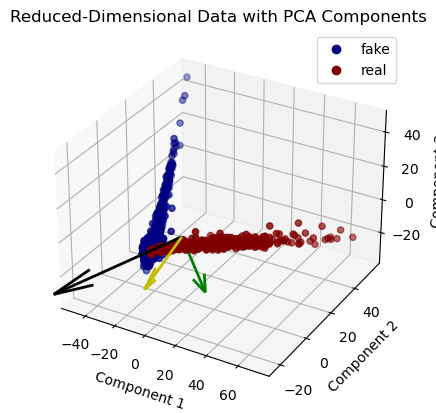

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Convert categorical labels to numeric values
label_encoder = LabelEncoder()
yd_test_encoded = label_encoder.fit_transform(yd_test)

# Plot the data points with colors based on yd_test_encoded
scatter = ax.scatter(Xd_test_reduced[:, 0], Xd_test_reduced[:, 1], Xd_test_reduced[:, 2], c=yd_test_encoded, cmap='jet', marker='o')


# Plot arrows for the eigenvectors
origin = np.mean(Xd_test_reduced, axis=0)
scale_factor = 2

ax.quiver(origin[0], origin[1], origin[2], Xd_test_reduced[0, 0]*scale_factor, Xd_test_reduced[1, 0]*scale_factor, Xd_test_reduced[2, 0]*scale_factor, color='black', linewidth=2)
ax.quiver(origin[0], origin[1], origin[2], Xd_test_reduced[0, 1]*scale_factor, Xd_test_reduced[1, 1]*scale_factor, Xd_test_reduced[2, 1]*scale_factor, color='green', linewidth=2)
ax.quiver(origin[0], origin[1], origin[2], Xd_test_reduced[0, 2]*scale_factor, Xd_test_reduced[1, 2]*scale_factor, Xd_test_reduced[2, 2]*scale_factor, color='y', linewidth=2)

# Set plot properties
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('Reduced-Dimensional Data with PCA Components')
plt.legend(handles=scatter.legend_elements()[0], labels=['fake','real'])
plt.show()

### Handcrafted Features

In [18]:
!pip install lol

from lol import LOL

ERROR: Could not find a version that satisfies the requirement lol (from versions: none)
ERROR: No matching distribution found for lol


ModuleNotFoundError: No module named 'lol'

In [27]:
pip install lol

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement lol (from versions: none)
ERROR: No matching distribution found for lol


In [1]:
import numpy as np

print(np.unique(yh_train_encoded))  # or just len(set(yh_train_encoded))

NameError: name 'yh_train_encoded' is not defined

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
yh_train_encoded = label_encoder.fit_transform(yh_train)

lmao = LDA(n_components=3)
Xh_train_reduced = lmao.fit_transform(Xh_train, yh_train_encoded)
Xh_test_reduced = lmao.transform(Xh_test)

ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

# Classifying

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Deep Features

**Training**

In [16]:
model = LogisticRegression(solver='newton-cholesky')
LogisticRegression()
model.fit(Xd_train_reduced,yd_train)

LogisticRegression(solver='newton-cholesky')

**Evaluation**

              precision    recall  f1-score   support

        fake       1.00      0.99      1.00       519
        real       0.99      1.00      1.00       507

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026



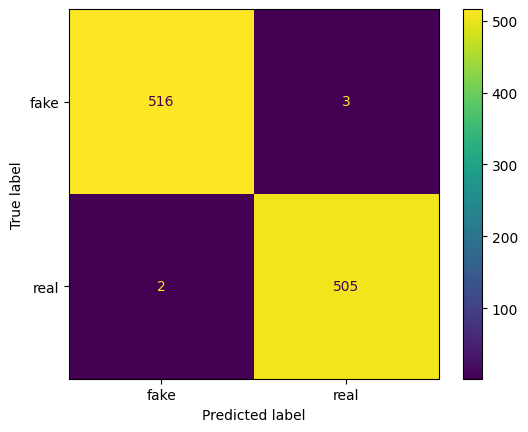

In [17]:
y_pred = model.predict(Xd_test_reduced)

print(classification_report(yd_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(yd_test,y_pred),display_labels=['fake','real']).plot();

### Handcrafted Features

**Training**

In [60]:
model = LogisticRegression(solver='newton-cholesky')
LogisticRegression()
model.fit(Xh_train_reduced,yh_train)

LogisticRegression(solver='newton-cholesky')

**Evaluation**

              precision    recall  f1-score   support

        fake       0.69      0.71      0.70       490
        real       0.73      0.71      0.72       536

    accuracy                           0.71      1026
   macro avg       0.71      0.71      0.71      1026
weighted avg       0.71      0.71      0.71      1026



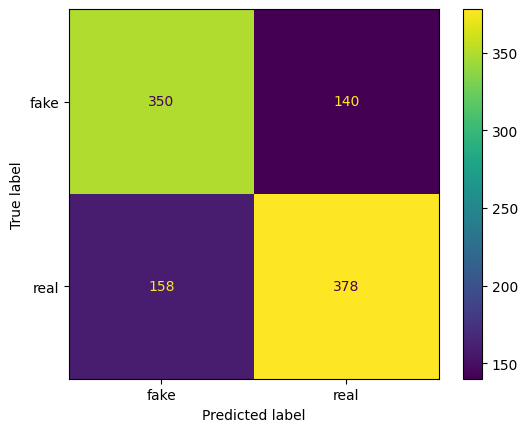

In [61]:
y_pred = model.predict(Xh_test_reduced)

print(classification_report(yh_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(yh_test,y_pred),display_labels=['fake','real']).plot();

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

### Deep Features

**Hyperparameter Tuning**

In [19]:
param_dist = {'n_estimators': np.arange(50,201,5),'max_depth': np.arange(20,201,5)}
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=5)
rand_search.fit(Xd_train_reduced, yd_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best Hyperparameters:',  rand_search.best_params_)

Best Hyperparameters: {'n_estimators': np.int64(75), 'max_depth': np.int64(20)}


**Evaluation**

              precision    recall  f1-score   support

        fake       1.00      0.99      1.00       519
        real       0.99      1.00      1.00       507

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026



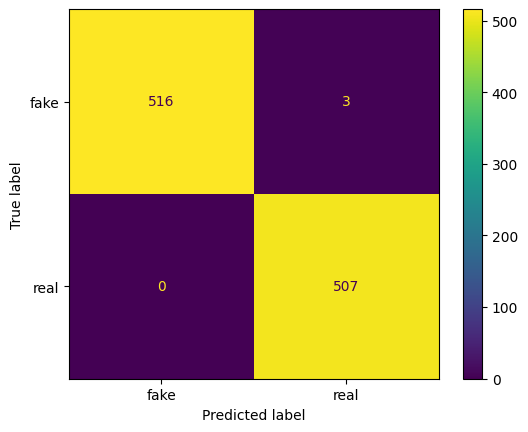

In [20]:
y_pred = best_rf.predict(Xd_test_reduced)

print(classification_report(yd_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(yd_test,y_pred),display_labels=['fake','real']).plot();

**Visualizing the Results**

In [21]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

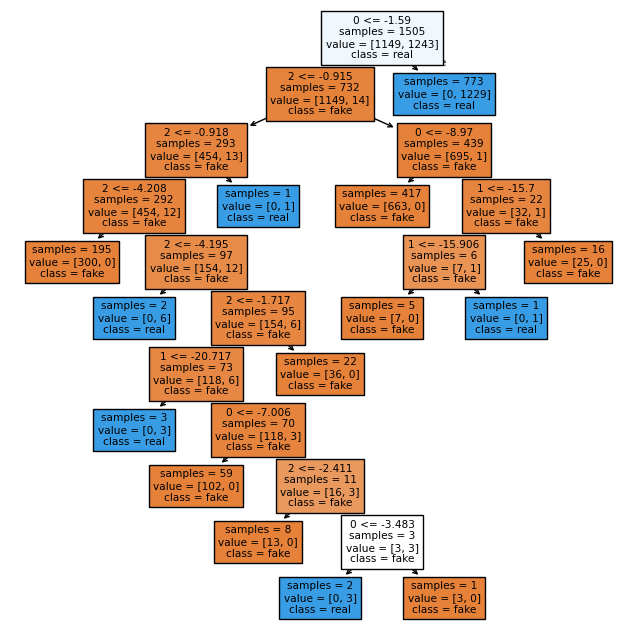

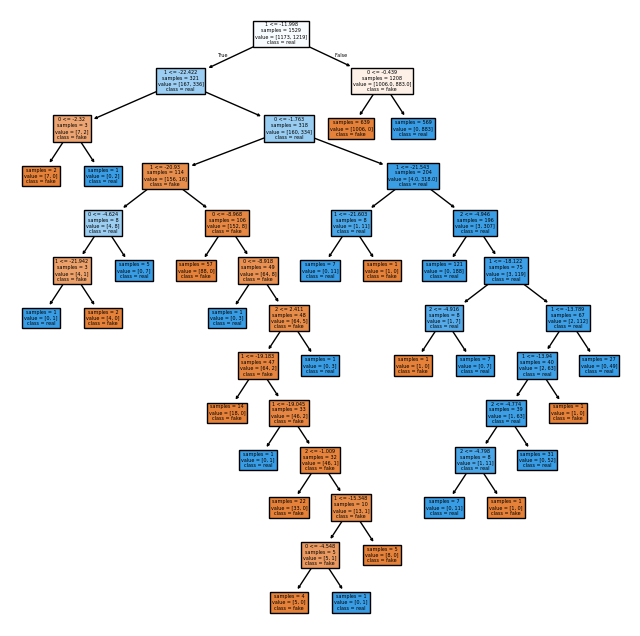

In [22]:
for i in range(2):
    fig = plt.figure(figsize=(8,8))
    tree = best_rf.estimators_[i]
    plot_tree(tree,
                   feature_names=Xd_train.columns,
                   class_names=['fake','real'],
                   filled=True,impurity=False)
    plt.show()

## SVC(SVM)

In [30]:
!pip install mlxtend

     ---------------------------------------- 1.4/1.4 MB 8.5 MB/s eta 0:00:00
     ---------------------------------------- 11.1/11.1 MB 9.2 MB/s eta 0:00:00
     ------------------------------------- 301.8/301.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.1
    Uninstalling scikit-learn-1.2.1:
      Successfully uninstalled scikit-learn-1.2.1


In [31]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder

### Deep Features

**Hyperparameter Tuning**

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Step 1: Define parameters and model
param = {'C': [0.1, 1, 10, 100]}
model = SVC(kernel='linear')

# Step 2: Grid search setup
grid_search = GridSearchCV(model, param_grid=param)

# Step 3: Fit to training data
grid_search.fit(Xd_train_reduced, yd_train)  # Make sure this line runs without error

# Step 4: Use the best model
best_model = grid_search.best_estimator_     # This will work only after fitting
best_model.fit(Xd_train_reduced, yd_train)   # Technically not needed again, but okay

# Step 5: Predictions
y_pred = best_model.predict(Xd_test_reduced)

# Step 6: Evaluation
print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(yd_test, y_pred))
print("Classification Report:\n", classification_report(yd_test, y_pred))

# Step 7: Save the best model
joblib.dump(best_model, 'svm_model.pkl')


Best Hyperparameters: {'C': 0.1}
Accuracy: 0.9951267056530214
Classification Report:
               precision    recall  f1-score   support

        fake       1.00      0.99      1.00       519
        real       0.99      1.00      1.00       507

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026



['svm_model.pkl']

In [41]:
train_score = grid_search.best_estimator_.score(Xd_train_reduced, yd_train)
test_score = grid_search.best_estimator_.score(Xd_test_reduced, yd_test)
print(f"Train Accuracy: {train_score}")
print(f"Test Accuracy: {test_score}")


Train Accuracy: 0.9945652173913043
Test Accuracy: 0.9951267056530214


In [42]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(grid_search.best_estimator_, Xd_train_reduced, yd_train, cv=5)
print("Cross-Validation Accuracy: ", scores.mean())


Cross-Validation Accuracy:  0.9954018570767202


              precision    recall  f1-score   support

        fake       1.00      0.99      1.00       519
        real       0.99      1.00      1.00       507

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026



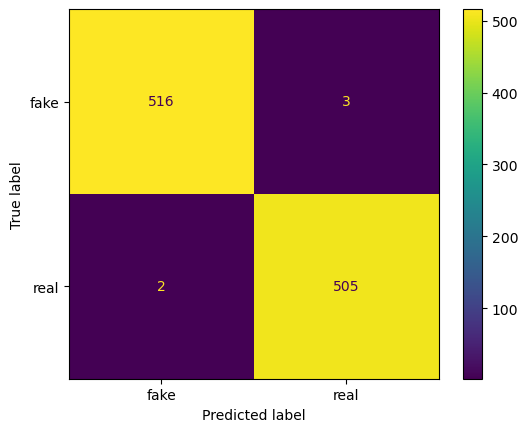

In [35]:
print(classification_report(yd_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(yd_test,y_pred),display_labels=['fake','real']).plot();

###Handcrafted Features

In [36]:
param = {'C': [0.1, 1, 10, 100]}
model = SVC(kernel='linear')
grid_search = GridSearchCV(model, param_grid=param)
grid_search.fit(Xh_train_reduced, yh_train)
print('Best Hyperparameters:',  grid_search.best_params_)

NameError: name 'Xh_train_reduced' is not defined

In [64]:
grid_search.best_estimator_.fit(Xh_train_reduced,yh_train)
y_pred = grid_search.best_estimator_.predict(Xh_test_reduced)

              precision    recall  f1-score   support

        fake       0.69      0.72      0.70       490
        real       0.73      0.70      0.71       536

    accuracy                           0.71      1026
   macro avg       0.71      0.71      0.71      1026
weighted avg       0.71      0.71      0.71      1026



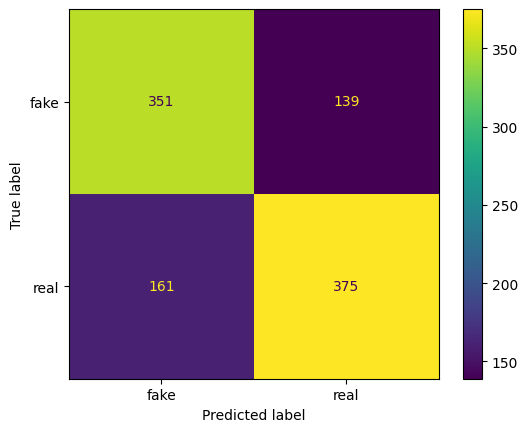

In [65]:
print(classification_report(yh_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(yh_test,y_pred),display_labels=['fake','real']).plot();

# Clustering

## Mini Batch K-Means

In [28]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import pandas as pd
from matplotlib import pyplot as plt
from kneed import KneeLocator

### Deep Features

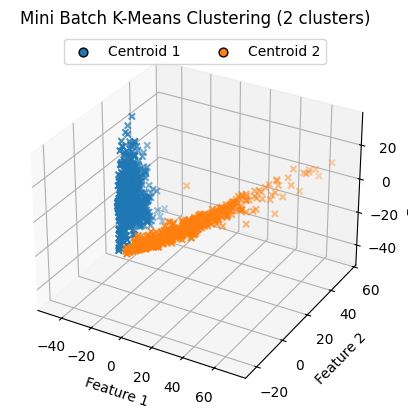

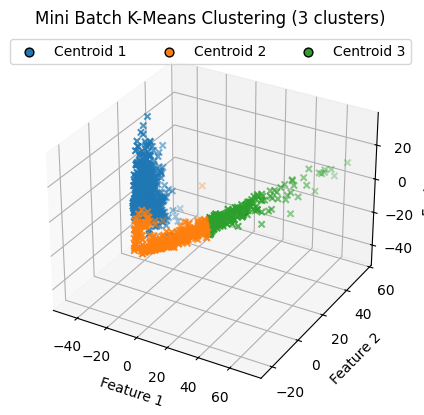

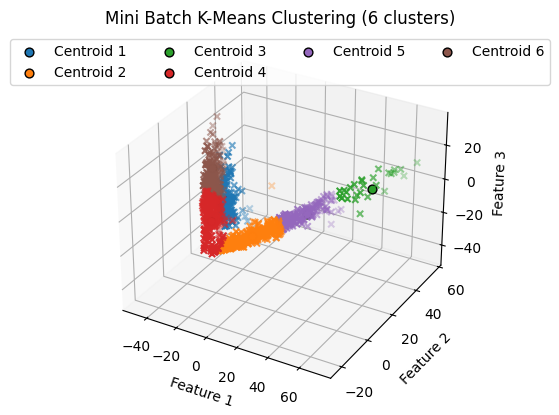

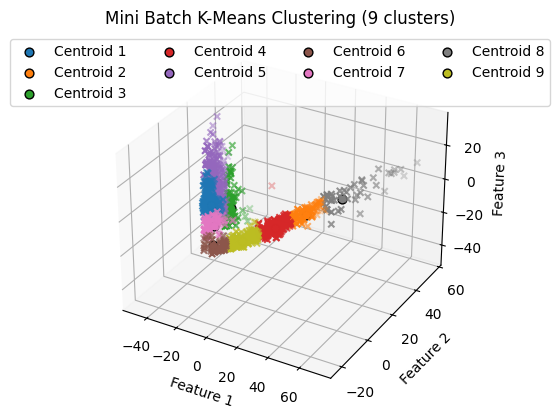

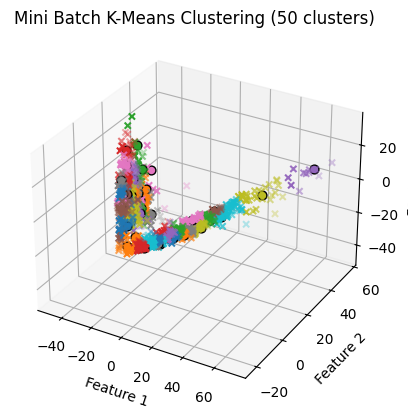

In [29]:
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

n_clusters = [2, 3, 6, 9, 50]
inertia = {}

for n in n_clusters:
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n, batch_size=25, n_init='auto', max_no_improvement=10)
    mbk.fit(Xd_train_reduced)
    yhat = mbk.predict(Xd_test_reduced)
    inertia[n] = mbk.inertia_
    clusters = np.unique(yhat)
    centroids = mbk.cluster_centers_

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for cluster in clusters:
        row_ix = np.where(yhat == cluster)[0]
        ax.scatter(
            Xd_test_reduced[row_ix, 0],
            Xd_test_reduced[row_ix, 1],
            Xd_test_reduced[row_ix, 2],
            c=[cm.tab10(cluster % 10)],
            marker='x'
        )

    for i, centroid in enumerate(centroids):
        ax.scatter(
            centroid[0],
            centroid[1],
            centroid[2],
            c=[cm.tab10(i % 10)],
            marker='o',
            edgecolors='k',
            s=40,
            label=f'Centroid {i + 1}'
        )

    if n < 20:
        ax.legend(loc='upper center', ncol=4)

    ax.set_title(f"Mini Batch K-Means Clustering ({n} clusters)")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')

    plt.show()


**Evaluation**

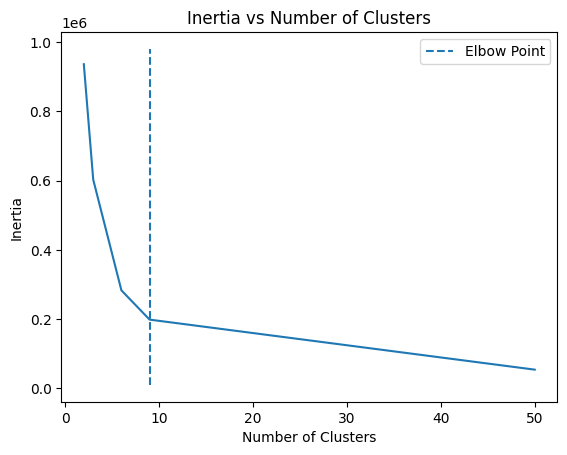

In [30]:
kneedle = KneeLocator(n_clusters, list(inertia.values()), curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

plt.plot(n_clusters, list(inertia.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',label='Elbow Point')
plt.legend()
plt.show()

### Handcrafted Features

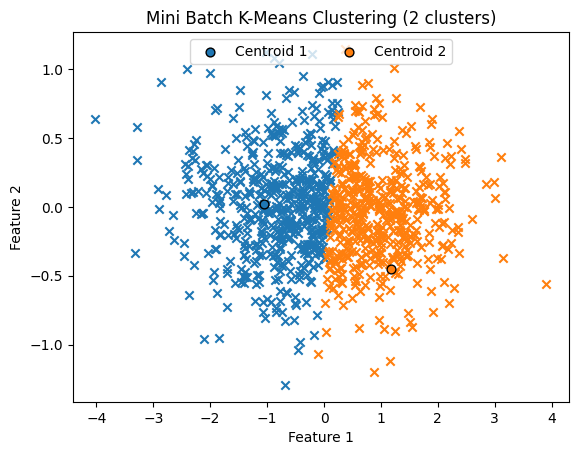

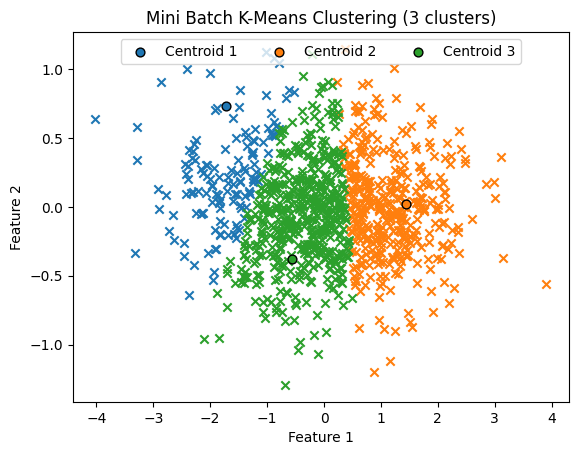

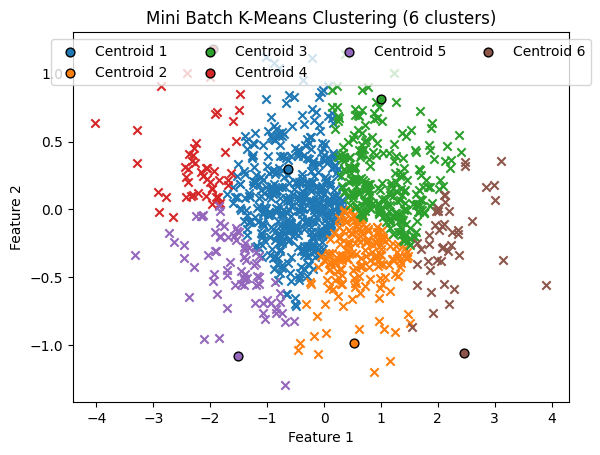

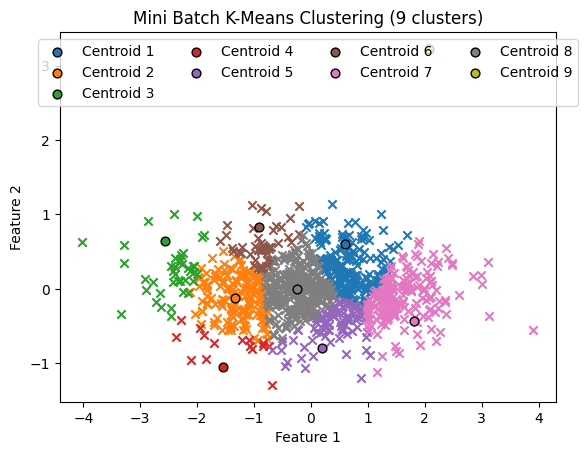

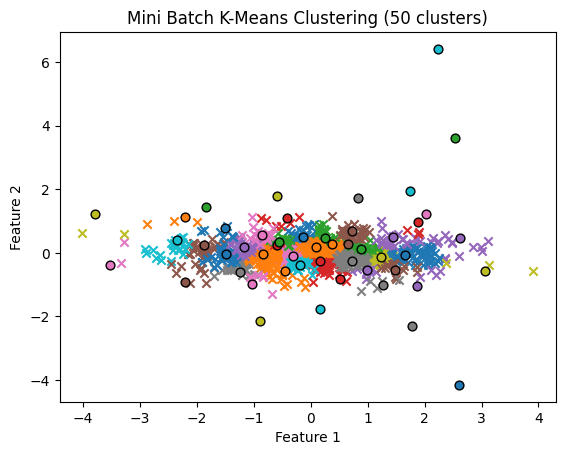

In [72]:
import matplotlib.pyplot as plt
from matplotlib import cm

n_clusters = [2, 3, 6, 9, 50]
inertia = {}

for n in n_clusters:
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n, batch_size=25, n_init='auto', max_no_improvement=10)
    mbk.fit(Xh_train_reduced)
    yhat = mbk.predict(Xh_test_reduced)
    inertia[n] = mbk.inertia_
    clusters = np.unique(yhat)
    centroids = mbk.cluster_centers_

    fig, ax = plt.subplots()

    for cluster in clusters:
        row_ix = np.where(yhat == cluster)[0]
        ax.scatter(
            Xh_test_reduced[row_ix, 0],
            Xh_test_reduced[row_ix, 1],
            c=[cm.tab10(cluster % 10)],
            marker='x'
        )

    for i, centroid in enumerate(centroids):
        ax.scatter(
            centroid[0],
            centroid[1],
            c=[cm.tab10(i % 10)],
            marker='o',
            edgecolors='k',
            s=40,
            label=f'Centroid {i + 1}'
        )

    if n < 20:
        ax.legend(loc='upper center', ncol=4)

    ax.set_title(f"Mini Batch K-Means Clustering ({n} clusters)")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

    plt.show()

**Evaluation**

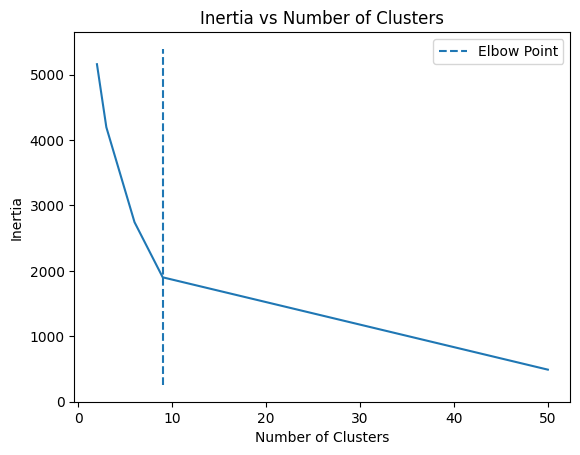

In [73]:
kneedle = KneeLocator(n_clusters, list(inertia.values()), curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

plt.plot(n_clusters, list(inertia.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',label='Elbow Point')
plt.legend()
plt.show()

## Gaussian Mixture Model

In [31]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

### Deep Features

In [32]:
n_clusters = [2, 3, 6, 9, 50]
aic_scores = []
bic_scores = []
for n in n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=123)
    gmm.fit(Xd_train_reduced)
    aic_scores.append(gmm.aic(Xd_test_reduced))
    bic_scores.append(gmm.bic(Xd_test_reduced))
    y_pred = gmm.predict(Xd_test_reduced)

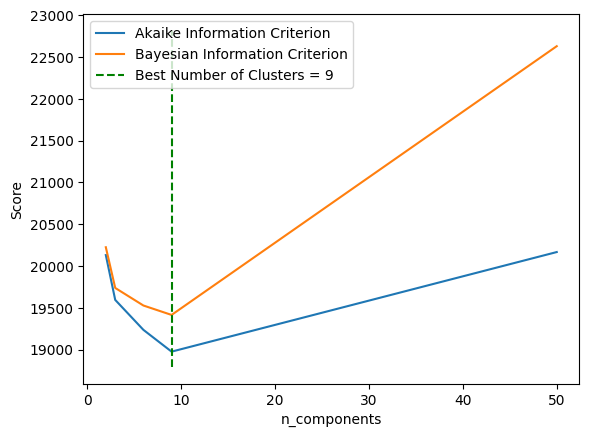

In [33]:
plt.plot(n_clusters, aic_scores, label='Akaike Information Criterion')
plt.plot(n_clusters, bic_scores, label='Bayesian Information Criterion')
best_n_clusters = n_clusters[bic_scores.index(min(bic_scores))]
plt.vlines(best_n_clusters, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',label=f"Best Number of Clusters = {best_n_clusters}",colors='g')
plt.xlabel('n_components')
plt.ylabel('Score')
plt.legend()
plt.show()

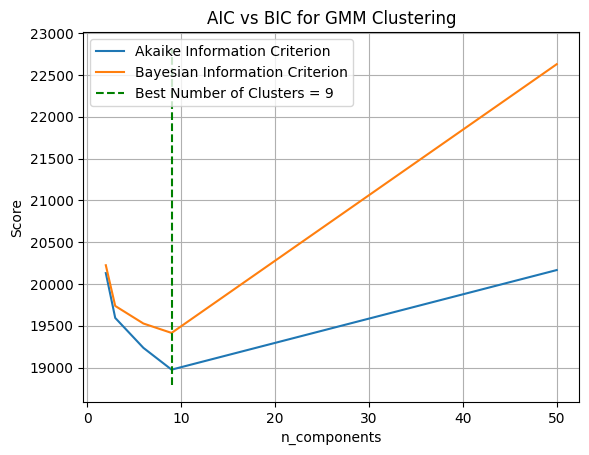

In [34]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_clusters = [2, 3, 6, 9, 50]
aic_scores = []
bic_scores = []

for n in n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=123)
    gmm.fit(Xd_train_reduced)
    aic_scores.append(gmm.aic(Xd_test_reduced))
    bic_scores.append(gmm.bic(Xd_test_reduced))

best_n_clusters = n_clusters[bic_scores.index(min(bic_scores))]

plt.plot(n_clusters, aic_scores, label='Akaike Information Criterion')
plt.plot(n_clusters, bic_scores, label='Bayesian Information Criterion')
plt.vlines(best_n_clusters, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',
           label=f"Best Number of Clusters = {best_n_clusters}", color='g')

plt.xlabel('n_components')
plt.ylabel('Score')
plt.title("AIC vs BIC for GMM Clustering")
plt.legend()
plt.grid(True)
plt.show()


### Handcrafted Features

In [91]:
n_clusters = [2, 3, 6, 9, 50]
aic_scores = []
bic_scores = []
for n in n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=123)
    gmm.fit(Xh_train_reduced)
    aic_scores.append(gmm.aic(Xh_test_reduced))
    bic_scores.append(gmm.bic(Xh_test_reduced))
    y_pred = gmm.predict(Xh_test_reduced)

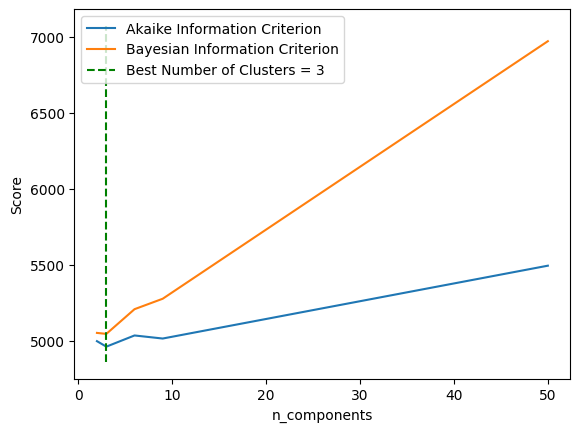

In [92]:
plt.plot(n_clusters, aic_scores, label='Akaike Information Criterion')
plt.plot(n_clusters, bic_scores, label='Bayesian Information Criterion')
best_n_clusters = n_clusters[bic_scores.index(min(bic_scores))]
plt.vlines(best_n_clusters, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',label=f"Best Number of Clusters = {best_n_clusters}",colors='g')
plt.xlabel('n_components')
plt.ylabel('Score')
plt.legend()
plt.show()